<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction</a></span></li><li><span><a href="#What-is-an-univariate-LSTM?" data-toc-modified-id="What-is-an-univariate-LSTM?-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>What is an univariate LSTM?</a></span></li><li><span><a href="#Imports" data-toc-modified-id="Imports-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Helper-functions" data-toc-modified-id="Helper-functions-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Helper functions</a></span></li><li><span><a href="#Multiple-Input-Series" data-toc-modified-id="Multiple-Input-Series-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Multiple Input Series</a></span><ul class="toc-item"><li><span><a href="#Create-dataset" data-toc-modified-id="Create-dataset-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Create dataset</a></span></li><li><span><a href="#Vanilla-LSTM" data-toc-modified-id="Vanilla-LSTM-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Vanilla LSTM</a></span></li></ul></li><li><span><a href="#Multiple-Parallel-Series" data-toc-modified-id="Multiple-Parallel-Series-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Multiple Parallel Series</a></span><ul class="toc-item"><li><span><a href="#Create-dataset" data-toc-modified-id="Create-dataset-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Create dataset</a></span></li><li><span><a href="#Stacked-LSTM" data-toc-modified-id="Stacked-LSTM-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Stacked LSTM</a></span></li></ul></li><li><span><a href="#References" data-toc-modified-id="References-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>References</a></span></li></ul></div>

# Introduction
<hr style="border:2px solid black"> </hr>

<div class="alert alert-block alert-warning">
<font color=black>

**What?** Multivariate LSTM models

</font>
</div>

# What is an univariate LSTM?

<div class="alert alert-block alert-info">
<font color=black>

- Multivariate time series data means data where there is **more than one observation (=target)** for each time step.
- There are two main models that we may require with multivariate time series data; they are:
    - Multiple Input Series.
    - Multiple Parallel Series.

</font>
</div>

# Imports

In [2]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional, Flatten, TimeDistributed
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import ConvLSTM2D
import matplotlib.pyplot as plt
from matplotlib import rcParams

# Helper functions

In [26]:
def plotLearningHistory(history):
    """Plot learning history.
    """
    
    epochs = len(history.history[ "loss"]) 
    x = range(0, epochs)

    rcParams['figure.figsize'] = 15, 5
    rcParams['font.size'] = 20

    fig, ax = plt.subplots()
    ax.plot(x, history.history[ "loss"], 'r-', lw = 3, label = 'Train') 

    ax.legend() 
    plt.xlabel('Epochs')
    plt.ylabel("MSE")
    plt.title('Training history')

    ax.grid(which = "major", linestyle='-', linewidth='1.0', color='k')
    ax.grid(which = "minor", linestyle='--', linewidth='0.25', color='k')
    ax.tick_params(which = 'major', direction='in', length=10, width=2)
    ax.tick_params(which = 'minor', direction='in', length=6, width=2)
    ax.spines['bottom'].set_linewidth(3)
    ax.spines['left'].set_linewidth(3)
    plt.yscale('log')
    ax.minorticks_on()
    plt.show()

In [37]:
def predictNextValue(model, x_input):
    """Predict next value in the sequence.
    """
    x_input = x_input.reshape((1, n_steps, n_features))
    
    yhat = model.predict(x_input, verbose=0)

        
    print("Predict next value in the sequence: ", yhat[0][0])

# Multiple Input Series

## Create dataset

<div class="alert alert-block alert-info">
<font color=black>

- A problem may have two or more parallel input time series and an output time series that is dependent on the input time series.
- We can demonstrate this with a simple example of two parallel input time series where the output series is the simple addition of the input series.

</font>
</div>

In [3]:
# define input sequence
in_seq1 = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90])
in_seq2 = np.array([15, 25, 35, 45, 55, 65, 75, 85, 95])
out_seq = np.array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])

In [6]:
print(in_seq1)
print(in_seq2)
print(out_seq)

[10 20 30 40 50 60 70 80 90]
[15 25 35 45 55 65 75 85 95]
[ 25  45  65  85 105 125 145 165 185]


In [8]:
# This the standard way of stacking this type of series

# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = np.hstack((in_seq1, in_seq2, out_seq))

In [9]:
dataset

array([[ 10,  15,  25],
       [ 20,  25,  45],
       [ 30,  35,  65],
       [ 40,  45,  85],
       [ 50,  55, 105],
       [ 60,  65, 125],
       [ 70,  75, 145],
       [ 80,  85, 165],
       [ 90,  95, 185]])

<div class="alert alert-block alert-info">
<font color=black>

- LSTMs can support parallel input time series as separate variables or features.
- Therefore, we need to split the data into samples maintaining the order of observations across the two input sequences.

</font>
</div>

In [16]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [19]:
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)
print(X.shape, y.shape)

(7, 3, 2) (7,)


<div class="alert alert-block alert-info">
<font color=black>

- The first dimension is the number of samples, in this case 7. 
- The second dimension is the number of time steps per sample, in this case 3, the value specified to the function. - Finally, the last dimension specifies the number of parallel time series or the number of variables, in this case 2 for the two parallel series. 

</font>
</div>

In [20]:
# summarize the data
for i in range(len(X)):
    print(X[i], y[i])

[[10 15]
 [20 25]
 [30 35]] 65
[[20 25]
 [30 35]
 [40 45]] 85
[[30 35]
 [40 45]
 [50 55]] 105
[[40 45]
 [50 55]
 [60 65]] 125
[[50 55]
 [60 65]
 [70 75]] 145
[[60 65]
 [70 75]
 [80 85]] 165
[[70 75]
 [80 85]
 [90 95]] 185


## Vanilla LSTM

<div class="alert alert-block alert-info">
<font color=black>

- A Vanilla LSTM is an LSTM model that has a single hidden layer of LSTM units, and an output layer used to make a prediction.
- We need to pay attention to the array dimensions.

</font>
</div>

In [31]:
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]

model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [32]:
# Fit model
history = model.fit(X, y, epochs = 500, verbose = 0)

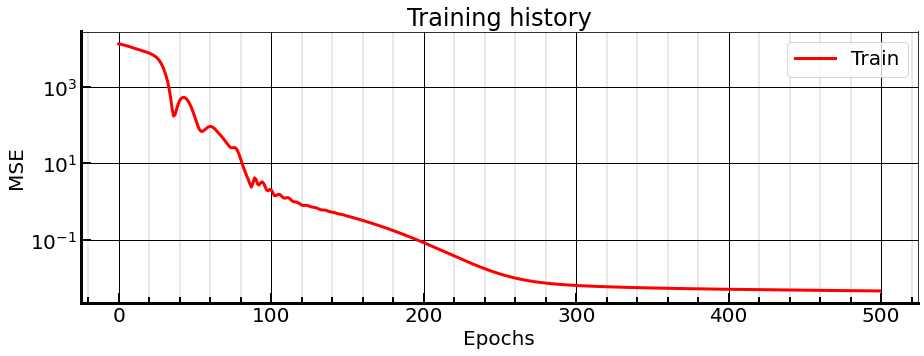

In [33]:
plotLearningHistory(history)

In [39]:
# Predicting the in-sample values
x_input = np.array([[70, 75], [80, 85], [90, 95]])
predictNextValue(model, x_input)

Predict next value in the sequence:  185.05298


In [38]:
# Predicting next time series
x_input = np.array([[80, 85], [90, 95], [100, 105]])
predictNextValue(model, x_input)

Predict next value in the sequence:  205.7139


# Multiple Parallel Series

<div class="alert alert-block alert-info">
<font color=black>

- An alternate time series problem is the case where there are multiple parallel time series and a value must be predicted for each.

</font>
</div>

## Create dataset

In [41]:
# define input sequence
in_seq1 = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90])
in_seq2 = np.array([15, 25, 35, 45, 55, 65, 75, 85, 95])
out_seq = np.array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])

In [42]:
print(out_seq)

[ 25  45  65  85 105 125 145 165 185]


In [44]:
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = np.hstack((in_seq1, in_seq2, out_seq))

In [45]:
print(dataset)

[[ 10  15  25]
 [ 20  25  45]
 [ 30  35  65]
 [ 40  45  85]
 [ 50  55 105]
 [ 60  65 125]
 [ 70  75 145]
 [ 80  85 165]
 [ 90  95 185]]


In [54]:
# split a multivariate sequence into samples
def split_sequences_v2(sequences, n_steps):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix > len(sequences)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [55]:
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences_v2(dataset, n_steps)
print(X.shape, y.shape)
# summarize the data
for i in range(len(X)):
    print(X[i], y[i])

(6, 3, 3) (6, 3)
[[10 15 25]
 [20 25 45]
 [30 35 65]] [40 45 85]
[[20 25 45]
 [30 35 65]
 [40 45 85]] [ 50  55 105]
[[ 30  35  65]
 [ 40  45  85]
 [ 50  55 105]] [ 60  65 125]
[[ 40  45  85]
 [ 50  55 105]
 [ 60  65 125]] [ 70  75 145]
[[ 50  55 105]
 [ 60  65 125]
 [ 70  75 145]] [ 80  85 165]
[[ 60  65 125]
 [ 70  75 145]
 [ 80  85 165]] [ 90  95 185]


## Stacked LSTM 

In [64]:
n_steps = 3
n_features = X.shape[2]

# define model
model1 = Sequential()
model1.add(LSTM(100, activation='relu', return_sequences=True,
           input_shape=(n_steps, n_features)))
model1.add(LSTM(100, activation='relu'))
model1.add(Dense(n_features))
model1.compile(optimizer='adam', loss='mse')

In [67]:
# Fit model
history1 = model1.fit(X, y, epochs=400, verbose=0)

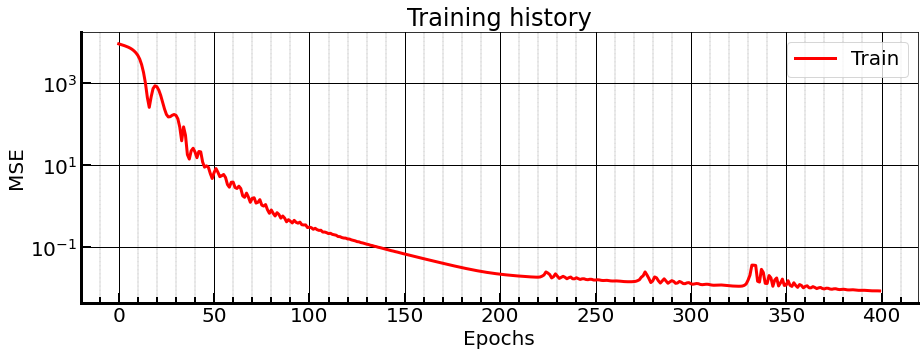

In [68]:
plotLearningHistory(history1)

In [71]:
# demonstrate prediction
x_input = np.array([[70,75,145], [80,85,165], [90,95,185]])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model1.predict(x_input, verbose=0)
print(yhat)

[[101.234825 106.15792  206.79256 ]]


# References
<hr style="border:2px solid black"> </hr>

<div class="alert alert-warning">
<font color=black>

- https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

</font>
</div>